In [ ]:
import onnxruntime as ort
import cv2
from ultralytics import YOLO
import os
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

In [123]:
model_path = "C:/Users/rohan/.insightface/models/buffalo_l/w600k_r50.onnx"
session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

face_detector = YOLO('C:/Users/rohan/General/Work/AIFellowShip/Project/FaceTagPlus/models/embeddings/runs/train/face_finetune/weights/best.pt')

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.look_up = pd.read_csv(os.path.join(root_dir, 'folder_stats.csv'))
    
    def __len__(self):
        return self.look_up.iloc[-1, -1]
    
    def __getitem__(self, idx):
        idx += 1
        df_idx = self.look_up['cumulative_sum'].searchsorted(idx, side='left')
        img_row = self.look_up.iloc[df_idx, :]
        if df_idx > 0:
            img_idx = idx - self.look_up.iloc[df_idx - 1, -1]
        else:
            img_idx = idx
        img_name = img_row['folder_name']
        img_path = os.path.join(self.root_dir, img_name, str(img_idx) + ".jpg")
        img = cv2.imread(img_path)                     # read image in BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, df_idx
        

In [ ]:
root = r"C:\Users\rohan\General\Work\AIFellowShip\Project\FaceTagPlus\data\raw\Dataset\Dataset"
datas = FaceDataset(root_dir=root)

In [ ]:
len(datas)

In [ ]:
import matplotlib.pyplot as plt
import cv2
from insightface.app import FaceAnalysis
model_path = "C:/Users/rohan/.insightface/models/buffalo_l/w600k_r50.onnx"
session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

face_detector = YOLO('C:/Users/rohan/General/Work/AIFellowShip/Project/FaceTagPlus/models/embeddings/runs/train/face_finetune/weights/best.pt')


def get_embeddings(img):

    boxes = face_detector.predict(img)[0].boxes.xyxy.cpu().numpy().astype(int).tolist()
    if len(boxes) == 0 or boxes is None:
        return None

    faces = np.stack([cv2.resize(img[y1:y2, x1:x2], (112, 112)) for x1, y1, x2, y2 in boxes]).transpose(0, 3, 1, 2)
    faces = (faces.astype(np.float32) - 127.5) / 127.5


    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    embedding = session.run([output_name], {input_name: faces})[0]

    return embedding

def get_embeddings_arcface(img):


    app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))


    if len(img.shape) == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img


    faces = app.get(img_rgb)

    if not faces:
        return None

    embeddings = np.array([face.embedding for face in faces])
    boxes = np.array([face.bbox for face in faces]).astype(int)  # optional if you need bounding boxes

    return embeddings

c:\Users\rohan\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

idxx = 233

plt.imshow(datas[idxx][0])
plt.axis('off') 
plt.show()
print(datas[idxx][1])


0: 640x640 1 face, 28.3ms
Speed: 20.4ms preprocess, 28.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.4ms
Speed: 6.3ms preprocess, 20.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.3ms
Speed: 8.3ms preprocess, 20.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.4ms
Speed: 6.2ms preprocess, 20.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.5ms
Speed: 7.3ms preprocess, 20.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.2ms
Speed: 5.6ms preprocess, 20.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 21.5ms
Speed: 6.7ms preprocess, 21.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 20.2ms
Speed: 5.5ms preprocess, 20.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640

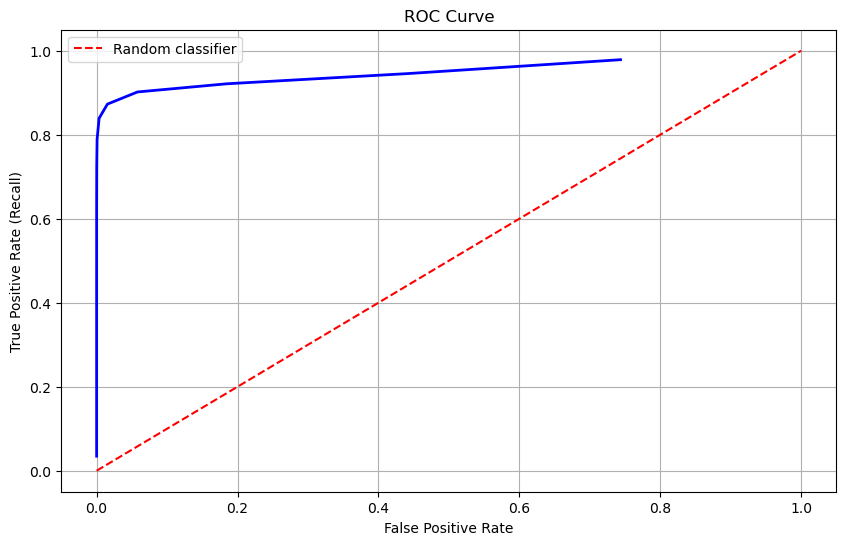

AUC: 0.6966


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


embeddings_list = []
labels_list = []

for img, label in datas:
    emb = get_embeddings(img)
    if emb is not None and emb.shape[0] == 1:
        embeddings_list.append(emb[0])
        labels_list.append(label)

embeddings_matrix = np.array(embeddings_list)  
labels_array = np.array(labels_list)  

print(f"Valid samples: {len(embeddings_list)} out of {len(datas)}")

similarity_matrix = cosine_similarity(embeddings_matrix)  

labels_match = labels_array[:, np.newaxis] == labels_array[np.newaxis, :]

thresholds = np.arange(0.0, 1.01, 0.05)  

results = []

for threshold in thresholds:
    predictions = similarity_matrix > threshold
    
    tp = np.sum(predictions & labels_match)
    fn = np.sum(~predictions & labels_match)
    fp = np.sum(predictions & ~labels_match)
    tn = np.sum(~predictions & ~labels_match)
    
 
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr
    })
    
    print(f"Threshold: {threshold:.2f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | "
          f"Rec: {recall:.4f} | F1: {f1:.4f}")


import pandas as pd
df_results = pd.DataFrame(results)
print("\n" + "="*80)
print(df_results.to_string(index=False))


best_idx = df_results['f1'].idxmax()
best_threshold = df_results.loc[best_idx, 'threshold']
print(f"\nBest threshold by F1 score: {best_threshold:.2f}")
print(f"Best F1 score: {df_results.loc[best_idx, 'f1']:.4f}")
df_results.to_csv('Yolo.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_results['fpr'], df_results['tpr'], 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import auc
roc_auc = auc(df_results['fpr'], df_results['tpr'])
print(f"AUC: {roc_auc:.4f}")

0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36